<a href="https://colab.research.google.com/github/tessavdheiden/Inverse_RL/blob/main/World_Model_Architecture_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State visitation frequency in pixel space
To perform inverse RL, we need to obtain the expectation of features over trajectories of the expert $\mathbb{E}_{\tau\sim\pi^E}[\phi(\tau)]$, with $\tau=(s_0,\dots,s_T)$.
In many domains $s$ is an image, $x\in\mathbb{R}^{|H|\times|W|}$ or with speed information, it is $x\in\mathbb{R}^{T\times|H|\times|W|}$.

One can handcraft a feature map $\phi:\mathbb{R}^{|H|\times|W|}\rightarrow \mathbb{R}^d$, specific to an application but that unfortunately, might not work accross domains.

One can also learn a feature map, for example, represent it with a network $f_\phi:\mathcal{S}\rightarrow\mathbb{R}^d$, where $f_\phi$ is trained maximising the log-likelihood of bad versus good states. 

In [1]:
!apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay
!wget http://www.atarimania.com/roms/Roms.rar
!unrar x /content/Roms.rar /content
!python -m atari_py.import_roms .

Streaming output truncated to the last 5000 lines.
Extracting  /content/ROMS/Bank Heist (Hack) (32 in 1) (Bit Corporation) (R320).bin       3%  OK 
Extracting  /content/ROMS/Bank Heist (Unknown) (PAL) [a].bin               3%  OK 
Extracting  /content/ROMS/Bank Heist (Unknown) (PAL).bin                   3%  OK 
Extracting  /content/ROMS/Barnstorming (1982) (Activision, Steve Cartwright) (AX-013) ~.bin       3%  OK 
Extracting  /content/ROMS/Barnstorming (CCE).bin                           3%  OK 
Extracting  /content/ROMS/Barnstorming (Unknown) (PAL) [a].bin             3%  OK 
Extracting  /content/ROMS/Barnstorming (Unknown) (PAL).bin                 3%  OK 
Extracting  /content/ROMS/Barnstorming - Die tollkeuhnen Flieger (1982) (Activision, Steve Cartwright - Ariola) (EAX-013, PAX-013 - 711 013-720) (PAL).bin       3%  OK 
Extracting  /content/ROMS/Base Attack (1983) (Home Vision - Gem International Corporation 

In [10]:
from collections import deque
from google.colab import drive
import gym
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle
import pyvirtualdisplay
from pyvirtualdisplay import Display
import sklearn
from sklearn import decomposition
from sklearn import datasets
from sklearn import mixture
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import torchvision
from tqdm import tqdm

In [18]:
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
packages = [gym, matplotlib, np, pickle, pyvirtualdisplay, sklearn, torch, torchvision, tqdm]
package_lst = ""
for package in packages:
  try:
    package_lst += f"{package.__name__}=={package.__version__}\n"
  except:
    pass

with open('/content/drive/MyDrive/ResearchProjects/IRL/requirements.txt', 'w') as f:
    f.write(package_lst)

In [ ]:
%matplotlib inline
torch.manual_seed(0) # set random seed
gym.logger.set_level(40) # suppress warnings (please remove if gives error)

display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# Auto-encoder

In [ ]:
seq_length = 4
RIGHT=4
LEFT=5
ep_time = 300

In [ ]:
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
  img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
  return img

def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float()

def collect_data(env_id, seq_len, capacity, policy=None, nrand=5):
  env = gym.make(env_id)
  
  n_seq_per_ep = (ep_time-seq_length) // seq_length
  n_ep = max(1, int(np.ceil(capacity / n_seq_per_ep)))
  
  data = {'input': [], 'label': [], 'action': [], 'rew': []}

  for _ in range(n_ep):
    tau = []
    tra = []
    rew = []

    env.reset()
    frame, _, _, _ = env.step(1)

    for _ in range(nrand):
      fr1, re1, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
      fr2, re2, _, _ = env.step(0)

    for t in range(ep_time):
      batch_input = preprocess_batch([fr1,fr2])
      probs = policy(batch_input).squeeze().cpu().detach().numpy()
      action = np.where(np.random.rand() < probs, RIGHT, LEFT)

      fr1, re1, is_done, _ = env.step(action)
      fr2, re2, is_done, _ = env.step(0)
      tau.append(torch.from_numpy(preprocess_single(fr1)))
      tra.append(F.one_hot(torch.tensor(action)-RIGHT, num_classes=2))#env.action_space.n
      rew.append(torch.tensor([re1+re2]))

    for start in range(0, len(tau)-seq_length, seq_length):
      # start = np.random.choice(len(tau)-seq_length-1)
      data['input'].append(torch.stack(tau[start:start+seq_length]))  
      data['label'].append(tau[start+seq_length])
      data['action'].append(torch.stack(tra[start:start+seq_length]))
      data['rew'].append(torch.stack())

  i = np.random.choice(capacity, capacity, replace=False)
  for k, v in data.items():
    data[k] = torch.stack(v).float()[i]
  env.close()
  return data

# Load Policy

In [ ]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [ ]:
drive.mount('/content/drive')
expert = Policy()
expert.load_state_dict(torch.load('/content/drive/MyDrive/ResearchProjects/IRL/models/policy_800_out_of_800'))
expert.eval()

Mounted at /content/drive


Policy(
  (conv1): Conv2d(2, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 16, kernel_size=(6, 6), stride=(4, 4))
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

# Visualisation Data

In [ ]:
capacity = 1

data = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = capacity,
    policy = expert
    )
print(data['input'].shape)

torch.Size([1, 4, 80, 80])


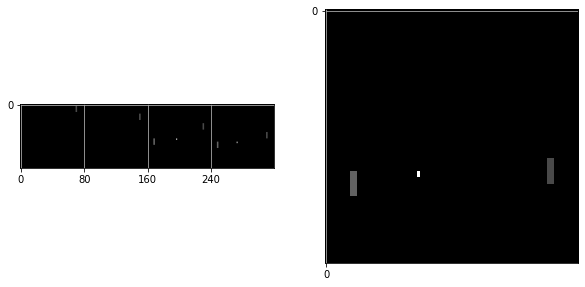

In [ ]:
batch_size, seq_len, h, w = data['input'].shape
f,ax=plt.subplots(figsize=(10,10),ncols=2)

grid_img = torchvision.utils.make_grid(data['input'].view(-1, 1, h, w), nrow=seq_len,padding=0,normalize=True)
ax[0].imshow(grid_img.permute(1, 2, 0), cmap='Greys')
ax[0].set_xticks(np.arange(0, seq_len*h, w))
ax[0].set_yticks(np.arange(0, batch_size*h, w))
ax[0].grid(which='both')

grid_img = torchvision.utils.make_grid(data['label'].view(-1, 1, h, w), nrow=batch_size,padding=0,normalize=True)
ax[1].imshow(grid_img.permute(1, 2, 0), cmap='Greys')
ax[1].set_xticks(np.arange(0, h, w))
ax[1].set_yticks(np.arange(0, batch_size*h, w))
ax[1].grid(which='both')

# Train Model

In [ ]:
class ActionAutoencoder(nn.Module):
    def __init__(self):
        super(ActionAutoencoder, self).__init__()
        h, w = 80, 80
        #Encoder
        x_dim = 4*h*w
        h1_dim = 4*h*w
        y_dim = h*w

        self.conv1 = nn.Conv2d(4, 8, kernel_size=6, stride=2, bias=False) 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=6, stride=4) # 38x38x4 to 9x9x32
        self.size=9*9*16
        
        # two fully connected layer
        h_dim = 128
        self.fc1 = nn.Linear(self.size, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)

        a_dim = 4*2
        self.a1 = nn.Linear(a_dim, a_dim*2) 
        self.a2 = nn.Linear(a_dim*2, a_dim*4) 
        self.a3 = nn.Linear(a_dim*4, a_dim*8) 
        self.a4 = nn.Linear(a_dim*8, a_dim*16) 
        self.a5 = nn.Linear(a_dim*16, a_dim*32) 
        
        h5_dim = h_dim+a_dim*32
        self.t_conv1 = nn.Linear(h5_dim, h5_dim) 
        #Decoder
        self.t_conv2 = nn.Linear(h5_dim, y_dim) 

    def encode(self, x, a):
        b, c, h, w = x.shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(b,-1)))
        x = F.relu(self.fc2(x))

        a = F.relu(self.a1(a.view(b,-1)))
        a = F.relu(self.a2(a))
        a = F.relu(self.a3(a))
        a = F.relu(self.a4(a))
        a = F.relu(self.a5(a))

        cat = torch.cat([x,a],dim=-1)
        x = F.relu(self.t_conv1(cat))
        return x

    def decode(self, x):
      x = self.t_conv2(x)
      return x

    def forward(self, x, a):
        b, c, h, w = x.shape
        x = self.encode(x, a)
        x = self.decode(x)
        return x.view(b, 1, h, w)

#Instantiate the model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = ActionAutoencoder().to(device)
# model(data['input'].float().to(device), data['action'].float().to(device)).shape#.to(device)).shape

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

capacity = 5000
t_start = time.time()
data = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = capacity,
    policy = expert
    )
print(time.time()-t_start)

data_test = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = 32,
    policy = expert

    )

59.842806577682495


In [ ]:
def merge_two_dicts(x, y):
    z = {}
    for (kx,vx), (ky,vy) in zip(x.items(),y.items()):
      z[kx] = torch.cat([vx, vy], dim=0)  
    return z

b_rand_pol = False

if b_rand_pol:
  capacity = 1000
  t_start = time.time()
  policy_rand = Policy()
  data_rand = collect_data(
      env_id = 'PongDeterministic-v4', 
      seq_len = seq_length,
      capacity = capacity,
      policy = policy_rand
      )
  print(time.time()-t_start)
  data_test_rand = collect_data(
      env_id = 'PongDeterministic-v4', 
      seq_len = seq_length,
      capacity = 32,
      policy = policy_rand
      )

  data = merge_two_dicts(data, data_rand)
  data_test = merge_two_dicts(data_test, data_test_rand)

16.023872137069702


In [ ]:
model = ActionAutoencoder().to(device)
adam = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.MSELoss()

n_epochs = 1000
results = {'train':[], 'test':[]}

t_start = time.time()

for k, v in data.items():
  data[k] = v.to(device)

for k, v in data_test.items():
  data[k] = v.to(device)

for _ in tqdm(range(n_epochs)):
  i = np.random.choice(np.arange(capacity),capacity,replace=False)
  x, y, a = data['input'][i], data['label'][i], data['action'][i]
  adam.zero_grad()
  yhat = model(x, a)
  error = loss(yhat.squeeze(1), y)
  error.backward()
  adam.step()
  results['train'].append(error.item())

  with torch.no_grad():
    x, y, a = data_test['input'], data_test['label'], data_test['action']
    yhat = model(x, a)
    error = loss(yhat.squeeze(1), y)
    results['test'].append(error.item())

print(time.time()-t_start)

RuntimeError: ignored

0.000108


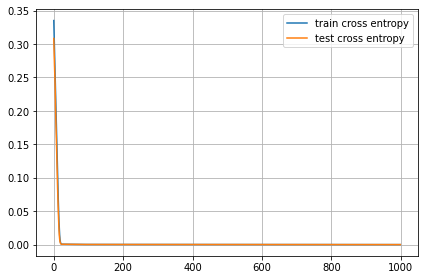

In [ ]:
plt.plot(results['train'], label='train cross entropy')
plt.plot(results['test'], label='test cross entropy')
plt.grid('minor')
plt.legend()
plt.tight_layout()
avg = np.asarray(results['test'][-100:]).mean()
print(f'{avg:.6f}')

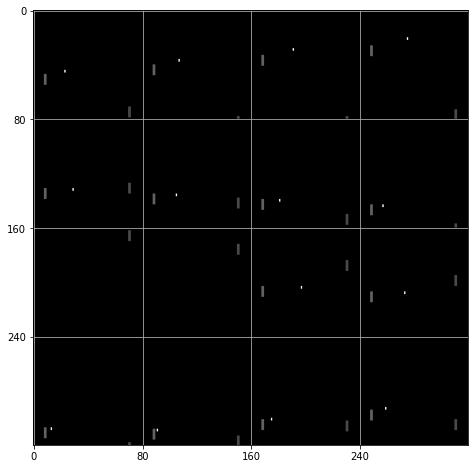

In [ ]:
data_val = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = 4,
    policy = expert
    )

batch_size, seq_len, h, w = data_val['input'].shape
f,ax=plt.subplots(figsize=(2*batch_size,2*batch_size))
grid_img = torchvision.utils.make_grid(data_val['input'].view(-1, 1, h, w), nrow=seq_len,padding=0,normalize=True)
ax.imshow(grid_img.permute(1, 2, 0), cmap='Greys')

ax.set_xticks(np.arange(0, seq_len*h, w))
ax.set_yticks(np.arange(0, batch_size*h, w))
ax.grid(which='both')

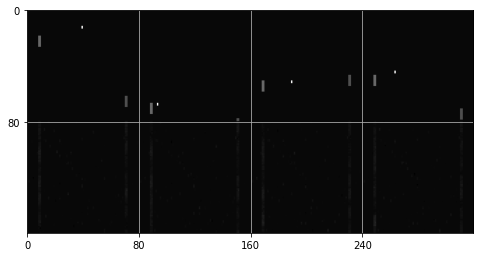

In [ ]:
f,ax=plt.subplots(figsize=(2*batch_size,2*batch_size))
with torch.no_grad():
  x, a = data_val['input'].float().to(device), data_val['action'].float().to(device)
  _,_,yhat = model(x, a)
  yhat = yhat.to('cpu')
y = data_val['label']
img = torch.stack([y.view(batch_size, h,w), yhat.view(batch_size, h,w)])
grid_img = torchvision.utils.make_grid(img.view(-1, 1, h, w), nrow=batch_size,padding=0,normalize=True)
ax.imshow(grid_img.permute(1, 2, 0), cmap='Greys')
ax.set_xticks(np.arange(0, batch_size*h, w))
ax.set_yticks(np.arange(0, 2*h, w))
ax.grid(which='both')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ResearchProjects/IRL/models/model')

In [ ]:
drive.mount('/content/drive')
with open('/content/drive/MyDrive/ResearchProjects/IRL/data/data.pkl', 'wb') as f:
    pickle.dump(data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dimension reduction

In [ ]:
model.to('cpu')
model.eval()
with torch.no_grad():
  x, a = data['input'].float().cpu(), data['action'].float().cpu()
  yhat = model.encode(x, a)

pca = PCA(0.99, whiten=True)
new_yhat = pca.fit_transform(yhat)
print(new_yhat.shape)

(2000, 63)


In [ ]:
model.to('cpu')
model.eval()
with torch.no_grad():
  x, a = data['input'].float().cpu(), data['action'].float().cpu()
  yhat = model.encode(x, a)

n_components = 64
gmm = mixture.GaussianMixture(n_components=n_components).fit(yhat)
print(gmm.converged_)


NameError: ignored

<BarContainer object of 64 artists>

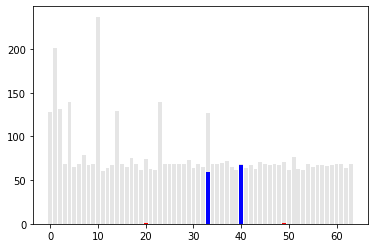

In [ ]:
i_pos = np.where(data['rew'][:,-1] == 1)[0]
i_neg = np.where(data['rew'][:,-1] == -1)[0]
plt.bar(np.arange(n_components), gmm.predict_proba(yhat).sum(0), color='k', alpha=.1)
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_pos]).sum(0), color='b')
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_neg]).sum(0), color='r')

In [ ]:
i_likelihood = np.argsort(gmm.predict_proba(yhat).sum(0))[::-1]

In [ ]:
i_likelihood

array([11, 50, 22, 39, 19, 53, 43, 21, 52, 62, 12, 30, 41, 32, 38, 16,  5,
       55, 58, 46, 48, 56, 42, 57,  8, 13, 59, 34, 35, 63, 28, 27, 26, 47,
       15, 54,  6, 60, 61, 45, 40, 31, 18,  3,  9, 24, 25, 36, 49, 44, 37,
       29, 20, 17, 51,  7, 33,  0, 14,  2, 23,  4,  1, 10])

Text(0.5, 0, 'mixture component')

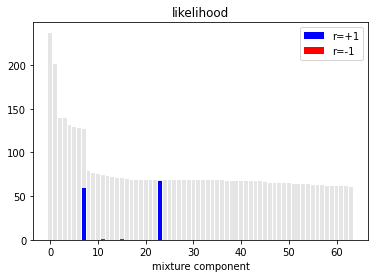

In [ ]:
i_pos = np.where(data['rew'][:,-1] == 1)[0]
i_neg = np.where(data['rew'][:,-1] == -1)[0]
plt.bar(np.arange(n_components), gmm.predict_proba(yhat).sum(0)[i_likelihood], color='k', alpha=.1)
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_pos]).sum(0)[i_likelihood], color='b', label='r=+1')
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_neg]).sum(0)[i_likelihood], color='r', label='r=-1')
plt.legend()
plt.title('likelihood')
plt.xlabel('mixture component')

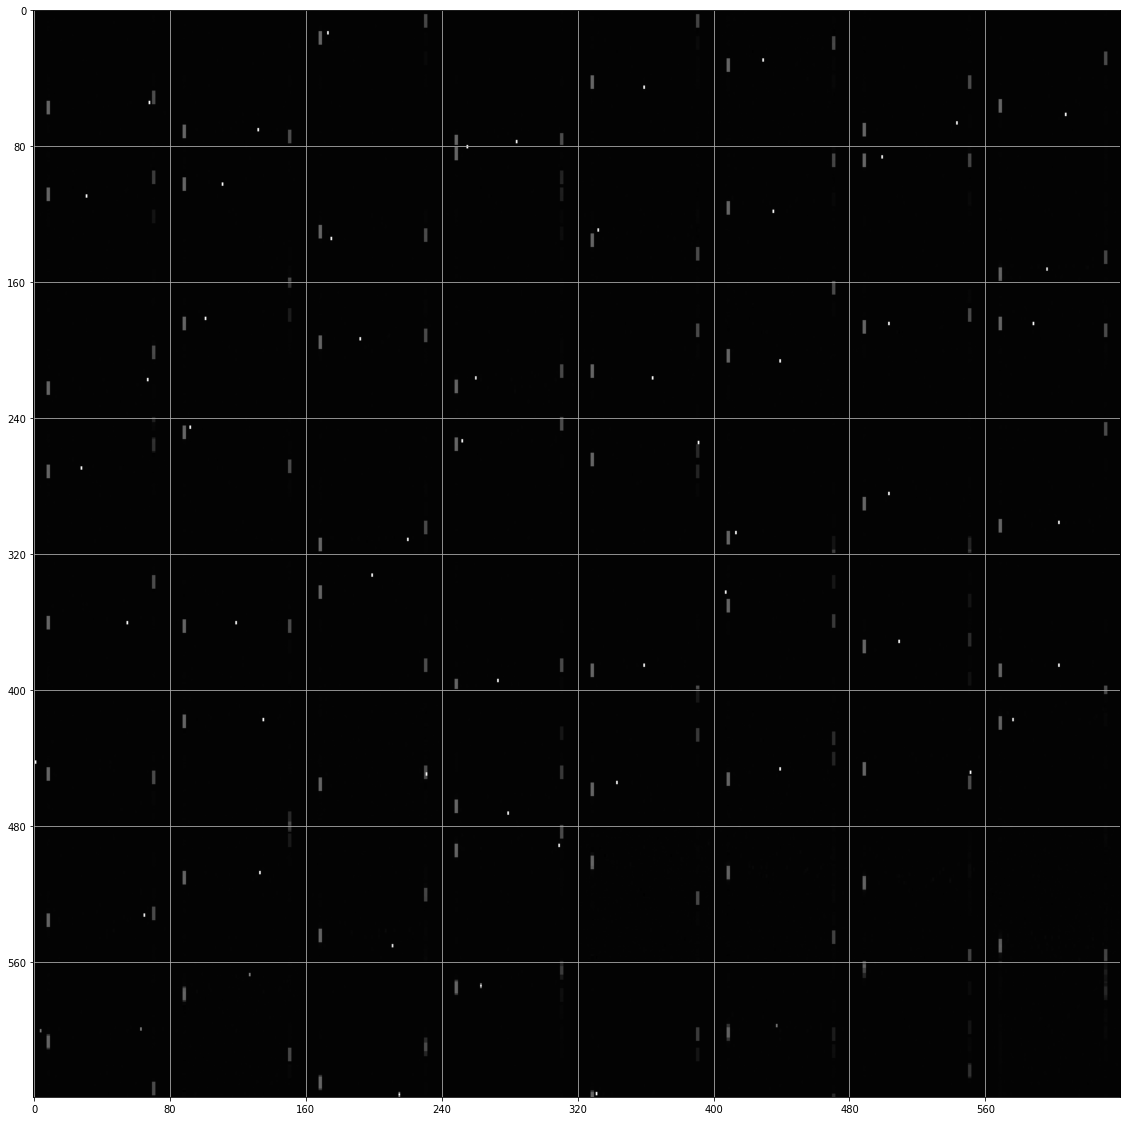

In [ ]:
decoded = []
for comp in i_likelihood[::-1]:
  t = torch.tensor(gmm.means_[comp])
  with torch.no_grad():
    decoded.append(model.decode(t.view(1,-1).float()).view(1, h,w))

decoded = torch.cat(decoded, dim=0)

f,ax=plt.subplots(figsize=(20,20))
nrows = int(np.sqrt(decoded.shape[0]))
grid_img = torchvision.utils.make_grid(decoded.view(-1, 1, h, w), nrow=nrows,padding=0,normalize=True)
ax.imshow(grid_img.permute(1, 2, 0), cmap='Greys')
ax.set_xticks(np.arange(0, nrows*h, w))
ax.set_yticks(np.arange(0, nrows*h, w))
ax.grid(which='both')

In [ ]:
# score = gmm.score_samples(yhat)
# (n, bins, patches) = plt.hist(score, bins=n_components, edgecolor="k", alpha=.1)

# i_pos = np.where(data['rew'] == 1)[0]
# i_neg = np.where(data['rew'] == -1)[0]

# score_pos = gmm.score_samples(yhat[i_pos])
# score_neg = gmm.score_samples(yhat[i_neg])
# (n, bins, patches) = plt.hist(score_pos, bins=bins, edgecolor="k", color="r", alpha=.4)
# (n, bins, patches) = plt.hist(score_neg, bins=bins, edgecolor="k", color="b", alpha=.4)

# plt.title('expert')

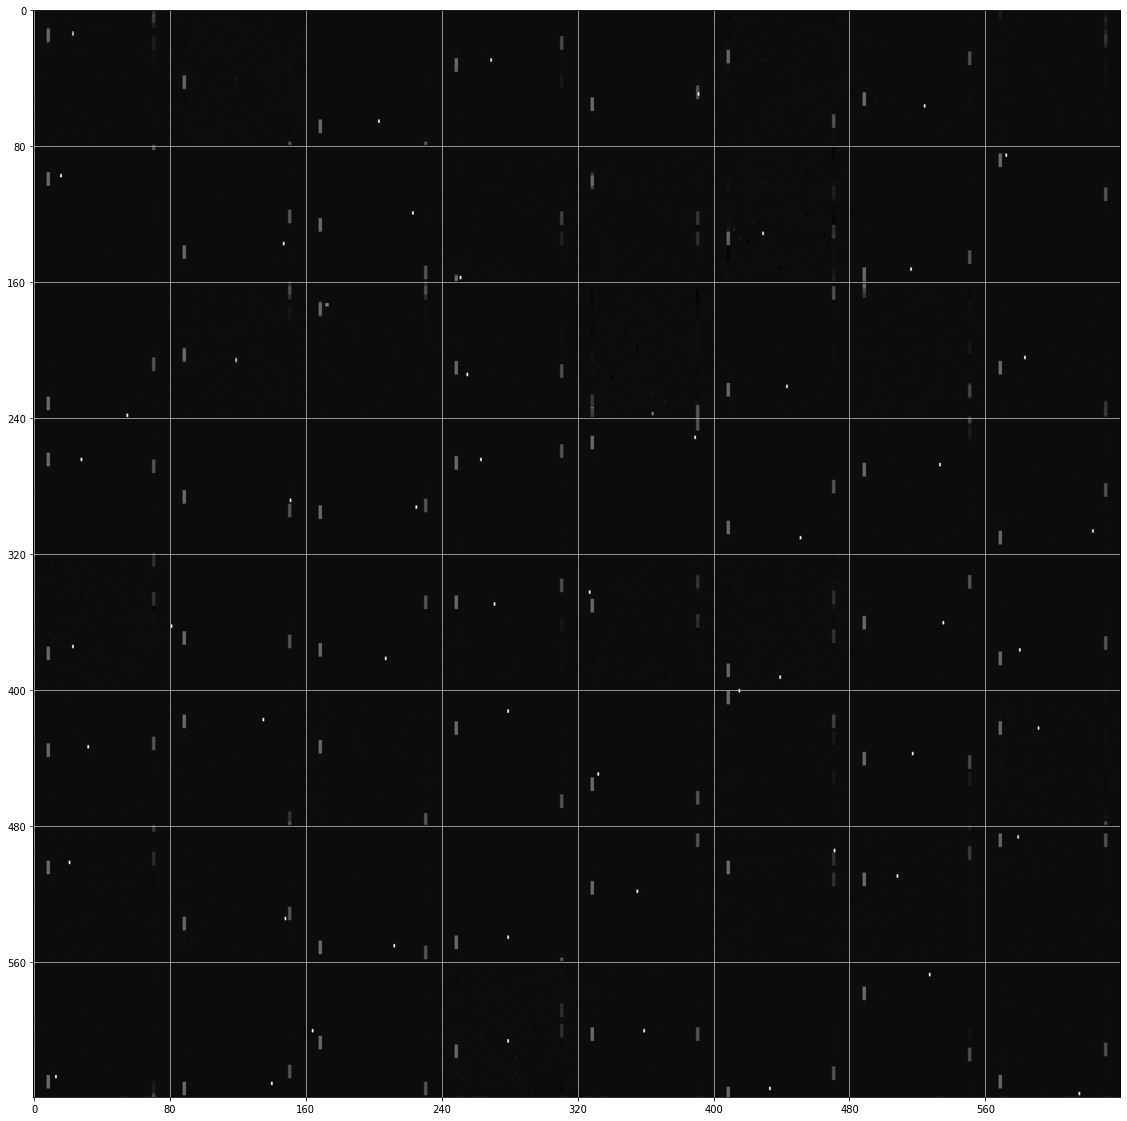

<BarContainer object of 64 artists>

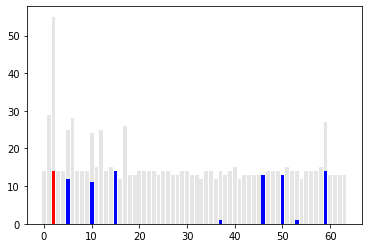

In [ ]:
plt.bar(np.arange(n_components), gmm.predict_proba(yhat).sum(0), color='k', alpha=.1)
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_pos]).sum(0), color='b')
plt.bar(np.arange(n_components), gmm.predict_proba(yhat[i_neg]).sum(0), color='r')

In [ ]:
np.argmax(gmm.predict_proba(yhat).sum(0))

2

0.02532831877873398

In [ ]:

mix = D.Categorical(torch.rand(3,5))
comp = D.Independent(D.Normal(
            torch.randn(3,5,2), torch.rand(3,5,2)), 1)
gmm = D.MixtureSameFamily(mix, comp)

In [ ]:
data_rand = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = capacity,
    policy = Policy()
    )

In [ ]:
with torch.no_grad():
  x_exp, a_exp = data['input'].float().cpu(), data['action'].float().cpu()
  x_rand, a_rand = data_rand['input'].float().cpu(), data_rand['action'].float().cpu()
  x = torch.cat([x_exp, x_rand], dim=0)
  a = torch.cat([a_exp, a_rand], dim=0)
  yhat = model.encode(x, a)

gmm = mixture.GaussianMixture(n_components=12).fit(yhat)
print(gmm.converged_)


True


Text(0.5, 1.0, 'expert')

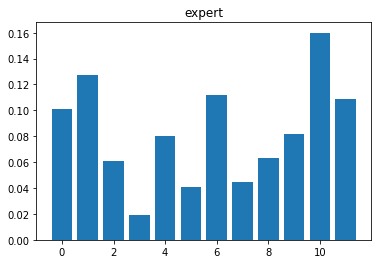

In [ ]:
with torch.no_grad():
  x, a = data['input'].float().cpu(), data['action'].float().cpu()
  yhat = model.encode(x, a)
prob = gmm.predict_proba(yhat)
plt.bar(np.arange(prob.shape[1]), prob.mean(0))
plt.title('expert')


Text(0.5, 1.0, 'learner')

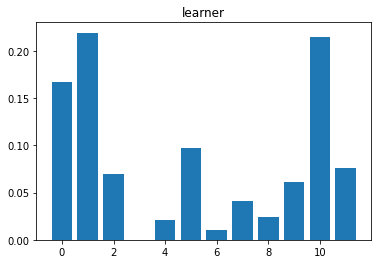

In [ ]:
with torch.no_grad():
  x, a = data_rand['input'].float().cpu(), data_rand['action'].float().cpu()
  yhat = model.encode(x, a)
prob = gmm.predict_proba(yhat)
plt.bar(np.arange(prob.shape[1]), prob.mean(0))
plt.title('learner')

In [ ]:
rew = torch.cat([data['rew'], data_rand['rew']], dim=0)
i_pos = np.where(rew == 1)[0]
i_neg = np.where(rew == -1)[0]

In [ ]:
i_pos = np.where(rew == 1)[0]
i_neg = np.where(rew == -1)[0]

In [ ]:
prob = gmm.predict_proba(yhat)
plt.bar(np.arange(prob[i_pos].shape[1]), prob[i_pos].sum(0), label="r=+1")
plt.bar(np.arange(prob[i_neg].shape[1]), prob[i_neg].sum(0), label="r=-1")
plt.legend()

IndexError: ignored

# Categorical

In [ ]:
inputsize = 80
kernel_size = 6
stride = 2
outputsize = (inputsize - kernel_size + stride)/stride
inputsize = outputsize
print(outputsize)
stride = 4
outputsize = (inputsize - kernel_size + stride)/stride
inputsize = outputsize
print(outputsize)
stride = 1
outputsize = (inputsize - kernel_size + stride)/stride
print(outputsize)

38.0
9.0
4.0


In [ ]:
inputsize = 128
stride = 1
kernel_size = 6
outputsize = (inputsize-1)*stride+kernel_size
print(outputsize)

133


In [ ]:
data['input'].min()

tensor(0.)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActionAutoencoder(nn.Module):
    def __init__(self):
        super(ActionAutoencoder, self).__init__()
        h, w = 80, 80
        #Encoder
        x_dim = 4*h*w
        h1_dim = 4*h*w
        y_dim = h*w

        self.conv1 = nn.Conv2d(4, 8, kernel_size=6, stride=2, bias=False) 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=6, stride=4) # 38x38x4 to 9x9x32
        self.size=9*9*16
        
        # two fully connected layer
        h_dim = 64
        self.fc1 = nn.Linear(self.size, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)

        a_dim = 4*2
        self.a1 = nn.Linear(a_dim, a_dim*2) 
        self.a2 = nn.Linear(a_dim*2, a_dim*4) 
        self.a3 = nn.Linear(a_dim*4, a_dim*8) 
        self.a4 = nn.Linear(a_dim*8, a_dim*16) 
        
        h5_dim = h_dim+a_dim*16
        self.t_conv1 = nn.Linear(h5_dim, h5_dim) 
        self.t_conv11 = nn.Linear(h5_dim, h5_dim) 
        #Decoder
        self.t_conv2 = nn.Linear(h5_dim, h5_dim) 
        self.t_conv3 = nn.Linear(h5_dim, h5_dim) 
        self.t_conv4 = nn.Linear(h5_dim, y_dim) 

    def encode(self, x, a):
        b, c, h, w = x.shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(b,-1)))
        x = F.relu(self.fc2(x))

        a = F.relu(self.a1(a.view(b,-1)))
        a = F.relu(self.a2(a))
        a = F.relu(self.a3(a))
        a = F.relu(self.a4(a))

        cat = torch.cat([x,a],dim=-1)
        x = F.relu(self.t_conv1(cat))
        x = self.t_conv11(cat)
        return x

    def forward(self, x, a):
        b, c, h, w = x.shape
        x = self.encode(x, a)

        # x = F.gumbel_softmax(x, dim=-1, hard=False)
        x = torch.sigmoid(x)

        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = self.t_conv4(x)
        return x.view(b, 1, h, w)

#Instantiate the model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = ActionAutoencoder().to(device)
# model(data['input'].float().to(device), data['action'].float().to(device)).shape#.to(device)).shape

In [ ]:
model = ActionAutoencoder().to(device)
adam = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.MSELoss()

n_epochs = 800
results = {'train':[], 'test':[]}

t_start = time.time()
for _ in range(n_epochs):
  i = np.random.choice(np.arange(capacity),capacity,replace=False)
  x, y, a = data['input'][i], data['label'][i], data['action'][i]
  adam.zero_grad()
  yhat = model(x.to(device), a.to(device))
  error = loss(yhat.squeeze(1), y.to(device))
  error.backward()
  adam.step()
  results['train'].append(error.item())

  with torch.no_grad():
    x, y, a = data_test['input'], data_test['label'], data_test['action']
    yhat = model(x.to(device), a.to(device))
    error = loss(yhat.squeeze(1), y.to(device))
    results['test'].append(error.item())

print(time.time()-t_start)

61.75393629074097


0.000159


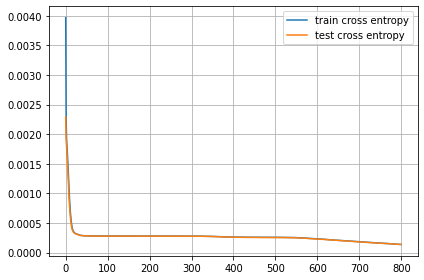

In [ ]:
plt.plot(results['train'], label='train cross entropy')
plt.plot(results['test'], label='test cross entropy')
plt.grid('minor')
plt.legend()
plt.tight_layout()
avg = np.asarray(results['test'][-100:]).mean()
print(f'{avg:.6f}')

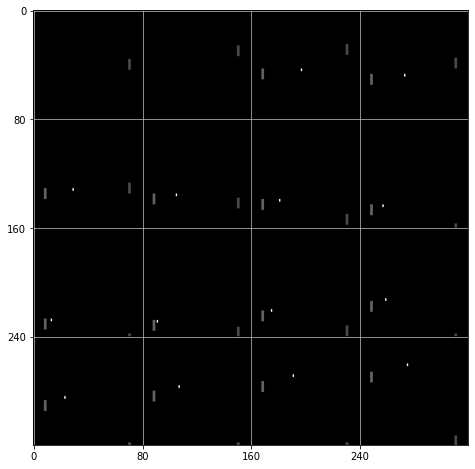

In [ ]:
data_val = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = 4,
    policy = expert
    )

batch_size, seq_len, h, w = data_val['input'].shape
f,ax=plt.subplots(figsize=(2*batch_size,2*batch_size))
grid_img = torchvision.utils.make_grid(data_val['input'].view(-1, 1, h, w), nrow=seq_len,padding=0,normalize=True)
ax.imshow(grid_img.permute(1, 2, 0), cmap='Greys')

ax.set_xticks(np.arange(0, seq_len*h, w))
ax.set_yticks(np.arange(0, batch_size*h, w))
ax.grid(which='both')

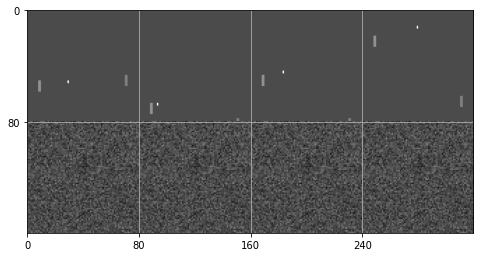

In [ ]:
f,ax=plt.subplots(figsize=(2*batch_size,2*batch_size))
model = ActionAutoencoder().to(device)
with torch.no_grad():
  x, a = data_val['input'].float().to(device), data_val['action'].float().to(device)
  yhat = model(x, a)
  yhat = yhat.to('cpu')
y = data_val['label']
img = torch.stack([y.view(batch_size, h,w), yhat.view(batch_size, h,w)])
grid_img = torchvision.utils.make_grid(img.view(-1, 1, h, w), nrow=batch_size,padding=0,normalize=True)
ax.imshow(grid_img.permute(1, 2, 0), cmap='Greys')
ax.set_xticks(np.arange(0, batch_size*h, w))
ax.set_yticks(np.arange(0, 2*h, w))
ax.grid(which='both')

# PCA

In [ ]:
model = ActionAutoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/ResearchProjects/IRL/models/model'))
model.eval()

ActionAutoencoder(
  (conv1): Conv2d(4, 8, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(8, 16, kernel_size=(6, 6), stride=(4, 4))
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (a1): Linear(in_features=8, out_features=16, bias=True)
  (a2): Linear(in_features=16, out_features=32, bias=True)
  (a3): Linear(in_features=32, out_features=64, bias=True)
  (a4): Linear(in_features=64, out_features=128, bias=True)
  (t_conv1): Linear(in_features=384, out_features=384, bias=True)
  (t_conv2): Linear(in_features=384, out_features=6400, bias=True)
)

In [ ]:
policy_random = Policy()
data_val_policy_random = collect_data(
    env_id = 'PongDeterministic-v4', 
    seq_len = seq_length,
    capacity = capacity,
    policy = policy_random
    )

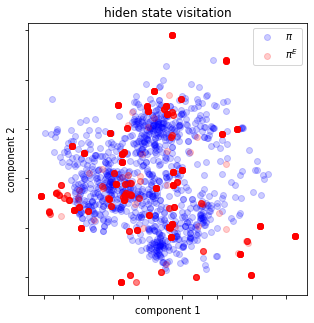

In [ ]:
f, ax = plt.subplots(figsize=(5, 5))
with torch.no_grad():
  x, a = data['input'].float().cpu(), data['action'].float().cpu()
  yhat = model.encode(x, a)

X = yhat

plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_exp = pca.transform(X)

with torch.no_grad():
  x, a = data_val_policy_random['input'].float().cpu(), data_val_policy_random['action'].float().cpu()
  yhat = model.encode(x, a)

X = yhat

plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
ax.scatter(X[:, 0], X[:, 1], label='$\pi$', alpha=.2, color='b')  
ax.scatter(X_exp[:, 0], X_exp[:, 1], label='$\pi^E$', alpha=.2, color='r')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_title('hiden state visitation')
plt.legend()
plt.show()

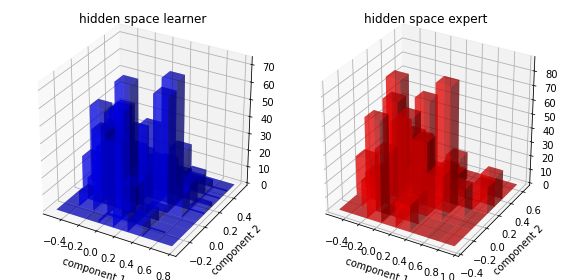

In [ ]:

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
axes = [ax, ax2]

hist, xedges, yedges = np.histogram2d(X[:,0], X[:,1], bins=(8,8))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average',alpha=.5)

hist, xedges, yedges = np.histogram2d(X_exp[:,0],  X_exp[:,1], bins=(8,8))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average',alpha=.5)
for a, title in zip(axes, ['learner','expert']):
  a.set_xlabel("component 1")
  a.set_ylabel("component 2")
  a.set_title('hidden space '+title)
plt.tight_layout()


# Continious state-space

In [ ]:
feature_matrix = get_feature_matrix(gw)
logits = torch.rand(n_states, requires_grad=True)
learning_rate = 0.01
adam = torch.optim.Adam([logits], lr=learning_rate)

loss = []
# Gradient descent on alpha.
for i in range(n_epochs):
    
    r = logits#.detach().numpy()
    
    v = optimal_value(
        gw.n_states, 
        gw.n_actions, 
        torch.from_numpy(gw.transition_probability).float(), 
        r, 
        discount=discount
    )
    policy = policy_from_value(
        v, 
        gw.n_actions, 
        torch.from_numpy(gw.transition_probability).float(),
        r, 
        discount
    )
    expected_svf = find_expected_svf(
        world = gw,
        n_states = gw.n_states, 
        policy = policy, 
        n_trajectories = n_trajectories,
        trajectory_length = trajectory_length,
        transition_probability=torch.from_numpy(gw.transition_probability).float()
    )

    expert = torch.tensor(feature_expectations/trajectories.shape[1])
    adam.zero_grad()
    kl_loss = kl_div(torch.softmax(logits, dim=-1), expert)
    # kl_loss = ((torch.softmax(logits, dim=-1) - expert)**2).sum()
    if kl_loss < 0: break
    print(f"i: {i} l: {kl_loss.item()}")
    kl_loss.backward()
    adam.step()

retrieved_r = feature_matrix.dot(alpha).reshape((n_states,))

In [ ]:
def find_expected_svf(
    n_states, n_trajectories, policy, trajectory_length, transition_probability, trajectories
):
      
    start_state_count = np.zeros(n_states)
    for trajectory in trajectories:
        s0 = int(trajectory[0, 0])
        start_state_count[s0] += 1
    p_start_state = start_state_count/n_trajectories
    
    expected_svf = torch.tensor(np.tile(p_start_state, (trajectory_length, 1)).T, requires_grad=True)

    for t in range(1, trajectory_length):
        # expected_svf[:, t] = 0
        for i, j, k in product(range(n_states), range(n_actions), range(n_states)):
            expected_svf[k, t] = expected_svf[k, t] + (expected_svf[i, t-1] *
                                  policy[i, j] * # Stochastic policy
                                  transition_probability[i, j, k])
            print(expected_svf[k, t])

    return expected_svf.sum(axis=1)

In [ ]:
def optimal_value(n_states, n_actions, transition_probability, reward, discount,threshold=1e-2):
  v = torch.zeros(n_states)

  diff = float("inf")
  while diff > threshold:
      diff = 0
      for s in range(n_states):
          max_v = float("-inf")
          for a in range(n_actions):
              tp = transition_probability[s, a, :]
              max_v = max(max_v, torch.dot(tp, reward + discount*v))

          new_diff = abs(v[s] - max_v)
          if new_diff > diff:
              diff = new_diff
          v[s] = max_v
  return v

In [ ]:
def policy_from_value(v, n_actions, transition_probability, reward, discount):
    # Get Q using equation 9.2 from Ziebart's thesis.
    n_states, n_actions = transition_probability.shape[0:2]
    Q = torch.zeros((n_states, n_actions))
    for i in range(n_states):
        for j in range(n_actions):
            p = transition_probability[i, j, :]
            Q[i, j] = p.dot(reward + discount*v)
    Q -= Q.max(axis=1)[0].view((n_states, 1))  # For numerical stability.
    Q = torch.exp(Q)/torch.exp(Q).sum(axis=1).view((n_states, 1))
    return Q

In [ ]:
def find_expected_svf(
    world, n_states, n_trajectories, policy, trajectory_length, transition_probability
):
  trajectories = []
  for _ in range(n_trajectories):
      sr, sc = 0, 0
      s = world._cell_to_index(np.array([sr, sc]))
      trajectory = []
      for _ in range(trajectory_length):
          # Follow the given policy.
          pvals = policy[s]
          a = np.argmax(np.random.multinomial(1, pvals=pvals.detach().numpy()))
          
          action = list(world.action_dict.keys())[a]
          s_ = world.act(s=s, a=action)
          
          r = world.reward(s)
          trajectory.append((int(s), a, r, pvals[a]))

          s = s_

      trajectories.append(trajectory)

  feature_matrix = torch.tensor(get_feature_matrix(world), requires_grad=True)

  feature_expectations = torch.zeros(feature_matrix.shape[1], requires_grad=True)

  for trajectory in trajectories:
      for state, _, _, a_prob in trajectory:
        state = int(state)
        feature_expectations = feature_expectations + feature_matrix[state] * a_prob

  feature_expectations /= (n_trajectories * trajectory_length)
  return feature_expectations

In [ ]:
f,ax = plt.subplots(figsize=(5,5), nrows=1)
with torch.no_grad():
  learner = torch.softmax(logits, dim=-1)

  ax.bar(np.arange(n_states), expert, alpha=.4, color='r')
  ax.bar(np.arange(n_states), learner.detach(), alpha=.4, color='b')
  ax.set_title(f'kl: {kl_div(learner, expert):.1f}')

In [ ]:
expert = torch.tensor(policy)
logits = torch.rand(policy.shape, requires_grad=True)
adam = torch.optim.Adam([logits], lr=0.1)

In [ ]:
f,ax = plt.subplots(figsize=(5,30),nrows=n_states)
with torch.no_grad():
  learner = torch.softmax(logits, dim=1)
  for s in range(n_states):
    ax[s].bar(np.arange(n_actions), expert[s], alpha=.4)
    ax[s].bar(np.arange(n_actions), torch.softmax(logits, dim=1)[s].detach(), alpha=.4)
    ax[s].set_title(f'kl: {kl_div(learner, expert):.1f}')

In [ ]:
import torch.nn.functional as F
for _ in range(10):
  adam.zero_grad()
  kl_loss = kl_div(torch.softmax(logits, dim=1), expert)
  if kl_loss < 0: break
  kl_loss.backward()
  adam.step()

In [ ]:
f,ax = plt.subplots(figsize=(5,30),nrows=n_states)
with torch.no_grad():
  learner = torch.softmax(logits, dim=1)
  for s in range(n_states):
    ax[s].bar(np.arange(n_actions), expert[s], alpha=.4)
    ax[s].bar(np.arange(n_actions), torch.softmax(logits, dim=1)[s].detach(), alpha=.4)
    ax[s].set_title(f'kl: {kl_div(learner, expert):.1f}')